# Using pretrained Places365 DCNN to categorize YFCC100M images.
----

Using Googlenet Model pretrained on Places365 to categorize YFCC100m Images.


In [1]:
%matplotlib inline
import mxnet as mx
import logging
import numpy as np
from skimage import io, transform
from collections import namedtuple

In [2]:
# Load the pre-trained model
prefix = "models/googlenet-places"
#prefix = "models/rn152-places"
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, 0)
mod = mx.mod.Module(symbol=sym, context=mx.gpu())
mod.bind([('data', (1,3,224,224))], for_training=False)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [3]:
# mean image
mean_rgb = np.array([123.68, 116.779, 103.939])
mean_rgb = mean_rgb.reshape((3, 1, 1))

In [4]:
# Load labels.
labels = []
with open('categories_places365.txt', 'r') as f:
    labels = [line.split()[0] for line in f]

Now we will use a YFCC100M and get a Places365 label for it. May be a bit slow the first time it's run.

In [5]:
def PreprocessImage(path, show_img=False):
    # load image.
    img = io.imread(path)
    # We crop image from center to get size 224x224.
    short_side = min(img.shape[:2])
    yy = int((img.shape[0] - short_side) / 2)
    xx = int((img.shape[1] - short_side) / 2)
    crop_img = img[yy : yy + short_side, xx : xx + short_side]
    resized_img = transform.resize(crop_img, (224,224))
    if show_img:
        io.imshow(resized_img)
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) * 256
    # swap axes to make image from (224, 224, 3) to (3, 224, 224)
    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    # sub mean 
    normed_img = sample# - mean_rgb
    normed_img = normed_img.reshape((1, 3, 224, 224))
    return [mx.nd.array(normed_img)]

Batch = namedtuple('Batch', ['data'])
def predict(imgname, prefix='../../../yfcc100m/images/'):
    # Get preprocessed batch (single image batch)
    batch = PreprocessImage(prefix + imgname, True)
    # Predict and show top 5 results!
    mod.forward(Batch(batch), is_train=False)
    prob = mod.get_outputs()[0].asnumpy()[0]
    #print(prob)
    #print(prob.shape)
    pred = np.argsort(prob)[::-1]
    for i in range(5):
        print((i+1, labels[pred[i]], prob[pred[i]]))

(1, '/f/field/cultivated', 0.86745667)
(2, '/f/field/wild', 0.043470062)
(3, '/g/greenhouse/indoor', 0.019473534)
(4, '/b/botanical_garden', 0.013965443)
(5, '/t/tundra', 0.0065316223)


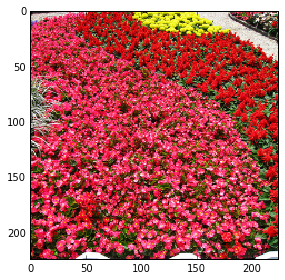

In [6]:
predict("bca/35b/bca35ba7147794c424b3d86f32d9f8d.jpg")

(1, '/t/tower', 0.23899326)
(2, '/s/skyscraper', 0.20424815)
(3, '/m/mosque/outdoor', 0.12002709)
(4, '/o/office_building', 0.083569519)
(5, '/d/downtown', 0.075822175)


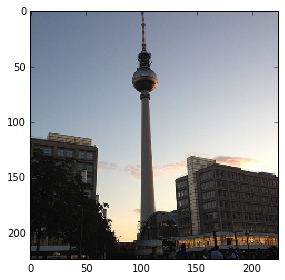

In [7]:
predict("e65/ccf/e65ccf71ece3f44df15581a47939e493.jpg")

(1, '/p/promenade', 0.20850721)
(2, '/d/downtown', 0.17928529)
(3, '/p/plaza', 0.10737674)
(4, '/b/bridge', 0.098121516)
(5, '/s/street', 0.066081233)


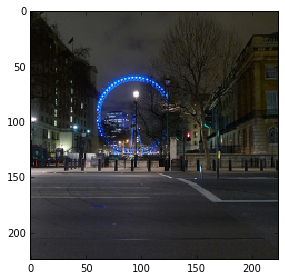

In [8]:
predict("2a4/e23/2a4e23bff43b78913990d2debf6b5c5.jpg")